In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Submission & Comments Count Statistics
------

In [3]:
base_dir = '../posts_categorization/linked_submissions_comments'
save_dir = '../posts_categorization/concatenated_linked_datasets'
os.makedirs(save_dir, exist_ok=True)

In [4]:
suicide_dfs = []
depression_dfs = []

for filename in tqdm(os.listdir(base_dir), desc='Processing files'):
    if filename.endswith(".csv"):
        filepath = os.path.join(base_dir, filename)
        if "suicide" in filename:
            suicide_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        elif "depression" in filename:
            depression_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        else:
            print("Error: Non-relevant datasets.")

concatenated_suicide_linked = pd.concat(tqdm(suicide_dfs, desc="Concatenating suicide data"), ignore_index=True)
concatenated_depression_linked = pd.concat(tqdm(depression_dfs, desc="Concatenating depression data"), ignore_index=True)

concatenated_suicide_linked = concatenated_suicide_linked.drop(concatenated_suicide_linked.columns[0], axis=1)
concatenated_depression_linked = concatenated_depression_linked.drop(concatenated_depression_linked.columns[0], axis=1)

linked_suicide_save_path = os.path.join(save_dir, "concatenated_suicide_linked.csv")
linked_depression_save_path = os.path.join(save_dir, "concatenated_depression_linked.csv")

concatenated_suicide_linked.to_csv(linked_suicide_save_path, index=False)
concatenated_depression_linked.to_csv(linked_depression_save_path, index=False)

Processing files:  50%|█████     | 4/8 [00:04<00:05,  1.42s/it]

Error: Non-relevant datasets.


Concatenating depression data: 100%|██████████| 3/3 [00:00<00:00, 62601.55it/s]


In [5]:
def analyze_submission_comment_distribution(dataframe):
    unique_submissions = dataframe[['submitter_username', 'content_submission', 'thread_id']].drop_duplicates()
    total_submissions = unique_submissions.shape[0]

    unique_comments = dataframe[['commenter_username', 'content_comment', 'thread_id']]
    total_comments = unique_comments.shape[0]

    submission_counts = unique_submissions.groupby('thread_id').size().reset_index(name='submission_count')

    comment_counts = unique_comments.groupby('thread_id').size().reset_index(name='comment_count')

    merged_counts = pd.merge(submission_counts, comment_counts, on='thread_id', how='left').fillna(0)

    plt.figure(figsize=(10, 6))
    plt.hist(merged_counts['comment_count'], bins=range(0, merged_counts['comment_count'].max() + 1), edgecolor='black')
    plt.title('Distribution of Comments per Submission')
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Submissions')
    plt.show()

    print(f"Total number of submissions: {total_submissions}")
    print(f"Total number of comments: {total_comments}")

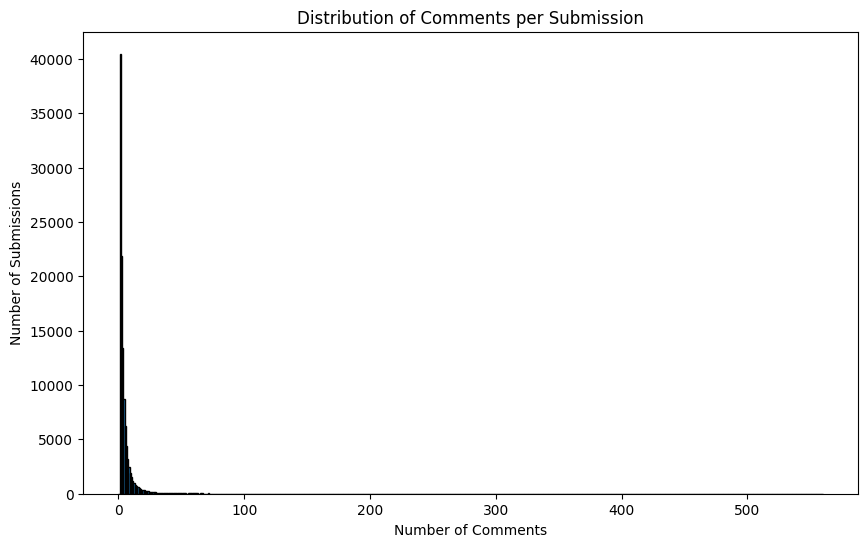

Total number of submissions: 114829
Total number of comments: 570077


In [6]:
analyze_submission_comment_distribution(concatenated_suicide_linked)

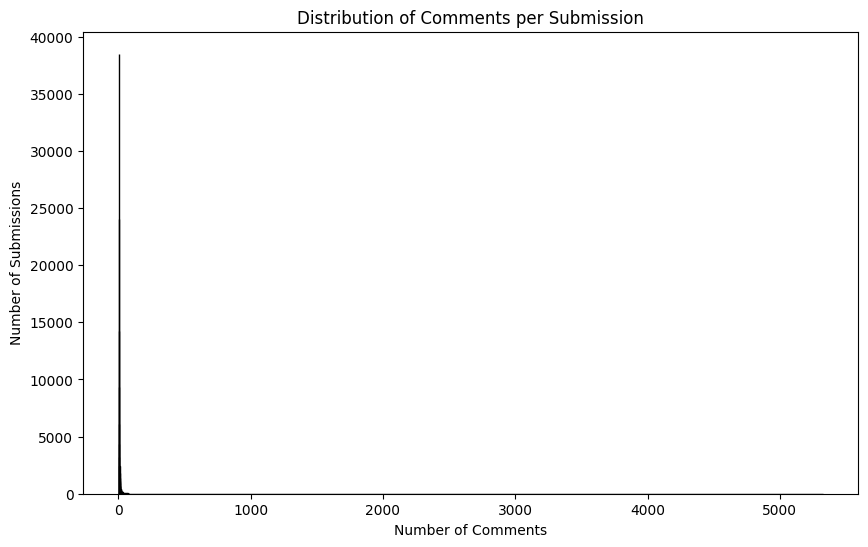

Total number of submissions: 115494
Total number of comments: 622216


In [7]:
analyze_submission_comment_distribution(concatenated_depression_linked)

In [8]:
def generate_category_statistics(year, subreddit_name, type, categ_methods=['llama', 'gemma', 'qwen']):
    if type == 'submissions':
        if year == 2020 or year == 2022 or year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'submissions_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['submissions_category', f'{categ_method}_submissions_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='submissions_category', how='outer')

        categ_stats_merged['mean_submissions_count'] = categ_stats_merged[[f'{categ_method}_submissions_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    elif type == 'comments':
        if year == 2020 or year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'comments_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['comments_category', f'{categ_method}_comments_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='comments_category', how='outer')

        categ_stats_merged['mean_comments_count'] = categ_stats_merged[[f'{categ_method}_comments_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    print(categ_stats_merged)

In [10]:
generate_category_statistics('all', 'suicide', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    83047                   100123   
1                    2                    20686                    12055   
2                    3                     1526                      372   
3                    4                     9570                     2279   

   qwen_submissions_count  mean_submissions_count  
0                   94056                92408.67  
1                   11072                14604.33  
2                    1618                 1172.00  
3                    8083                 6644.00  


In [11]:
generate_category_statistics('all', 'depression', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    80022                    89663   
1                    2                    30822                    24145   
2                    3                     1812                      678   
3                    4                     2838                     1008   

   qwen_submissions_count  mean_submissions_count  
0                   89393                86359.33  
1                   20107                25024.67  
2                    2658                 1716.00  
3                    3336                 2394.00  


In [12]:
generate_category_statistics('all', 'suicide', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                213554                309972   
1                 2                228160                 84033   
2                 3                 55872                 44127   
3                 4                 72491                131945   

   qwen_comments_count  mean_comments_count  
0               235672            253066.00  
1               134869            149020.67  
2                44376             48125.00  
3               155160            119865.33  


In [13]:
generate_category_statistics('all', 'depression', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                230233                323848   
1                 2                243288                 99080   
2                 3                 87129                 85250   
3                 4                 61566                114038   

   qwen_comments_count  mean_comments_count  
0               252618            268899.67  
1               164074            168814.00  
2                75360             82579.67  
3               130164            101922.67  


In [10]:
years = [2020, 2023, 2024]
subreddit_names = ['suicide', 'depression']
types = ['submissions', 'comments']

for year in years:
    print(year)
    for subreddit_name in subreddit_names:
        print(subreddit_name)
        for type in types:
            print(type)
            generate_category_statistics(year, subreddit_name, type)

2020
suicide
submissions
  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    39524                    47725   
1                    2                    10263                     6171   
2                    3                      776                      171   
3                    4                     4643                     1139   

   qwen_submissions_count  mean_submissions_count  
0                   44999                44082.67  
1                    5467                 7300.33  
2                     804                  583.67  
3                    3936                 3239.33  
comments
  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                 96548                140992   
1                 2                104400                 38662   
2                 3                 23925                 19087   
3                 4                 29759                

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_radar_chart(title, categories, data_sw, data_dp, filename):
    colors = {'LLaMA': '#9999FF', 'Gemma': '#99FF99', 'Qwen': '#FF9999'}
    labels = np.array(categories)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    def format_ticks(x, pos):
        if x >= 1000:
            return f'{int(x // 1000)}K'
        else:
            return str(int(x))
    for model, sw, dp, color in zip(['LLaMA', 'Gemma', 'Qwen'], data_sw, data_dp, colors.values()):
        sw_values = sw + sw[:1]
        dp_values = dp + dp[:1]

        ax.plot(angles, sw_values, color=color, linestyle='solid', linewidth=2, label=f"{model} SW")
        ax.plot(angles, dp_values, color=color, linestyle='dotted', linewidth=2, label=f"{model} DP")

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, wrap=True, fontsize=10, ha='center', va='center', fontweight='bold')
    ax.tick_params(axis='x', pad=35)  # Increased padding for x-axis labels
    ax.set_title(title, pad=20)  # Added padding to the title
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    ax.set_title(title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.8, 1.1), title="Count (in k, where k = 1,000)")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

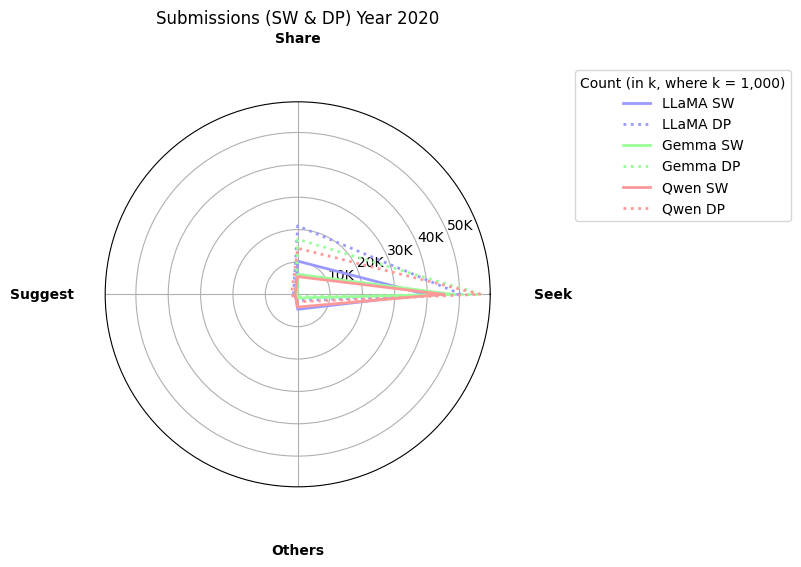

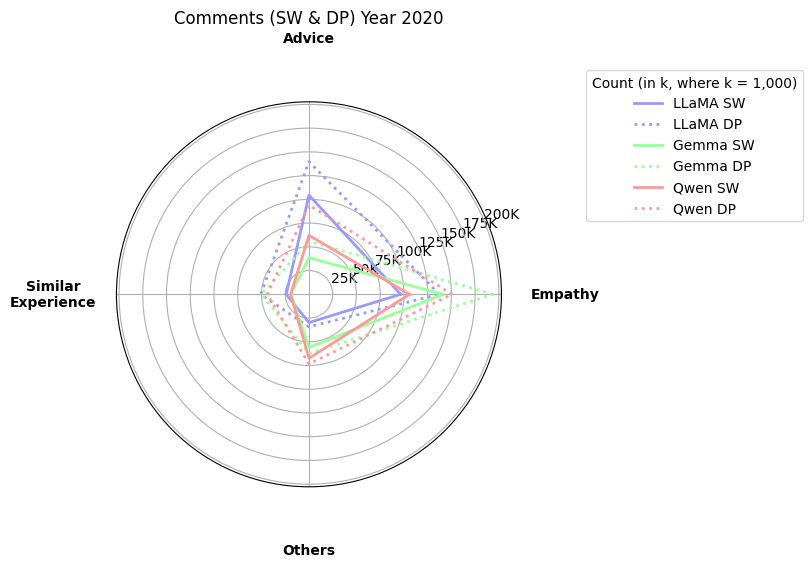

In [6]:
# 2020
# Data for submissions
categories_sub = ['Seek', 'Share', 'Suggest', 'Others']
data_sw_sub_2020 = [[39524, 10263, 776, 4643], [47725, 6171, 171, 1139], [44999, 5467, 804, 3936]]
data_dp_sub_2020 = [[50511, 21163, 1312, 1923], [56662, 17008, 508, 731], [56451, 14237, 1907, 2314]]
plot_radar_chart("Submissions (SW & DP) Year 2020", categories_sub, data_sw_sub_2020, data_dp_sub_2020, 'radar_charts/radar_submissions_2020.png')

# Data for comments
categories_com = ['Empathy', 'Advice', 'Similar Experience', 'Others']
data_sw_com_2020 = [[96548, 104400, 23925, 29759], [140992, 38662, 19087, 55891], [105874, 62144, 19259, 67355]]
data_dp_com_2020 = [[137295, 139783, 50726, 34273], [193983, 55900, 49815, 62379], [150798, 94022, 43948, 73309]]
plot_radar_chart("Comments (SW & DP) Year 2020", categories_com, data_sw_com_2020, data_dp_com_2020,'radar_charts/radar_comments_2020.png')

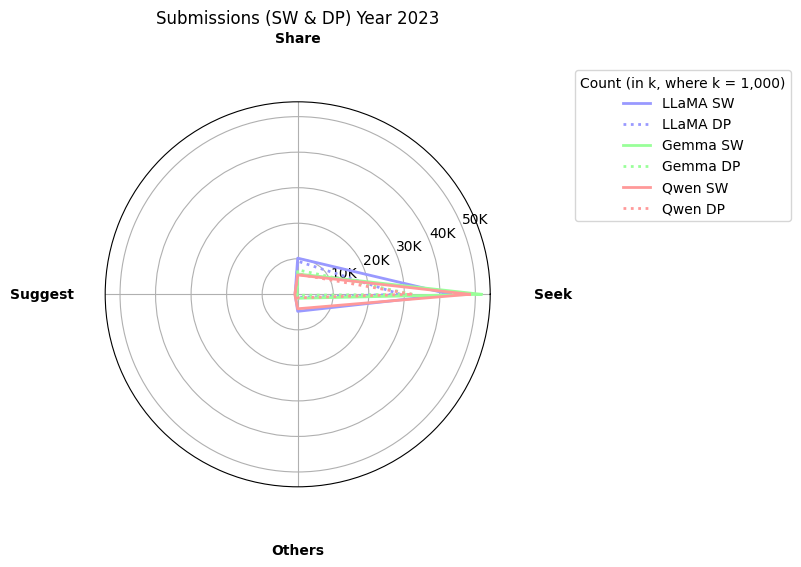

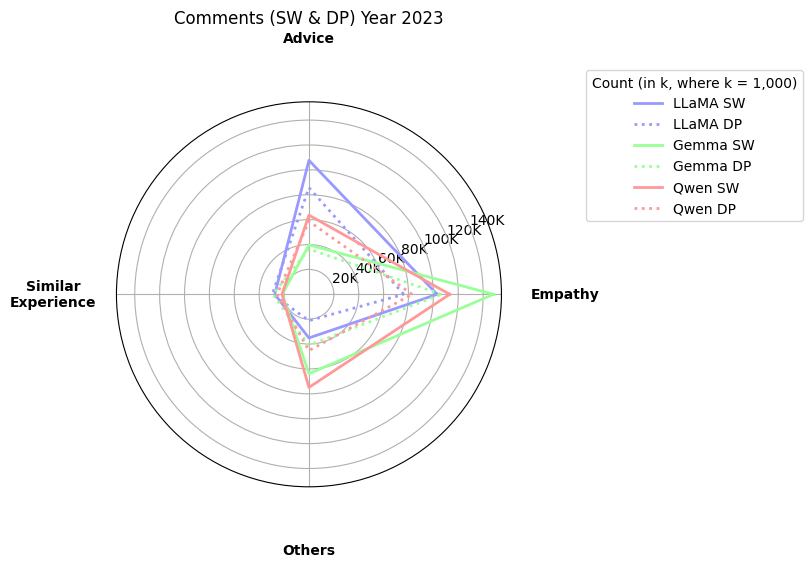

In [7]:
# 2023
# Data for submissions
categories_sub = ['Seek', 'Share', 'Suggest', 'Others']
data_sw_sub_2023 = [[42957, 10170, 732, 4792], [51605, 5728, 198, 1120], [48327, 5446, 808, 4070]]
data_dp_sub_2023 = [[28909, 9326, 491, 866], [32274, 6876, 169, 273], [32194, 5661, 746, 991]]
plot_radar_chart("Submissions (SW & DP) Year 2023", categories_sub, data_sw_sub_2023, data_dp_sub_2023, 'radar_charts/radar_submissions_2023.png')

# Data for comments
categories_com = ['Empathy', 'Advice', 'Similar Experience', 'Others']
data_sw_com_2023 = [[103028, 107659, 27463, 35066], [148351, 39673, 21387, 63805], [113107, 63630, 21631, 74848]]
data_dp_com_2023 = [[76177, 85736, 29447, 21191], [106426, 36348, 28885, 40892], [82929, 58720, 25677, 45225]]
plot_radar_chart("Comments (SW & DP) Year 2023", categories_com, data_sw_com_2023, data_dp_com_2023,'radar_charts/radar_comments_2023.png')

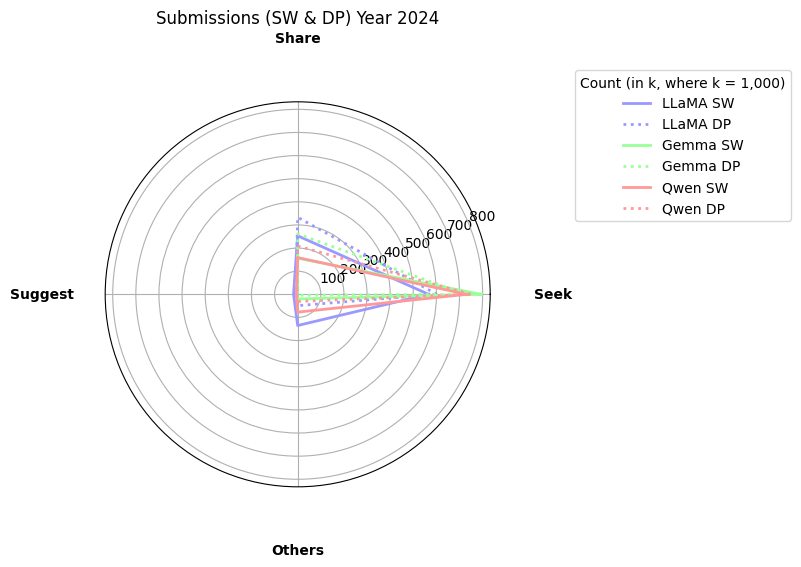

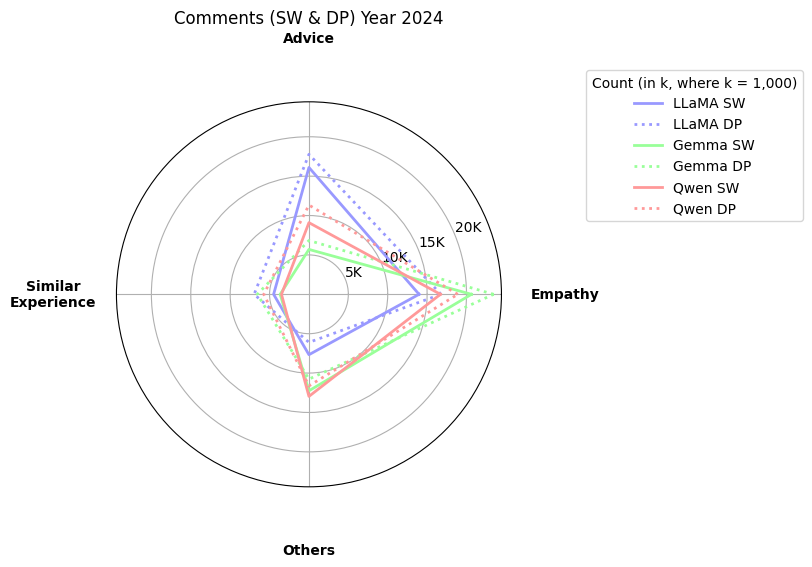

In [8]:
# 2024
# Data for submissions
categories_sub = ['Seek', 'Share', 'Suggest', 'Others']
data_sw_sub_2024 = [[566, 253, 18, 135], [793, 156, 3, 20], [730, 159, 6, 77]]
data_dp_sub_2024 = [[602, 333, 9, 49], [727, 261, 1, 4], [748, 209, 5, 31]]
plot_radar_chart("Submissions (SW & DP) Year 2024", categories_sub, data_sw_sub_2024, data_dp_sub_2024, 'radar_charts/radar_submissions_2024.png')

# Data for comments
categories_com = ['Empathy', 'Advice', 'Similar Experience', 'Others']
data_sw_com_2024 = [[13978, 16101, 4484, 7666], [20629, 5698, 3653, 12249], [16691, 9095, 3486, 12957]]
data_dp_com_2024 = [[16761, 17769, 6956, 6102], [23439, 6832, 6550, 10767], [18891, 11332, 5735, 11630]]
plot_radar_chart("Comments (SW & DP) Year 2024", categories_com, data_sw_com_2024, data_dp_com_2024,'radar_charts/radar_comments_2024.png')